## Considerations for PCA Analysis

- leave out target variable for PCA
- do pca only on related / correlated features to get a combined feature


## TODOs
- provide per column explanations and interpretations for the original features
- fix (coords in last scatter plot don't match loadings)
- interpretation of alcohol consumption (correlated with higher std of living!)
- reduce number of features by merging related features using their PCs

In [1]:
%matplotlib widget

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir = Path.cwd().parents[1] / "_data"

assert data_dir.exists(), data_dir
list(data_dir.glob("*.csv"))

[WindowsPath('C:/Users/chris/Documents/GitHub/ama_ws25/_data/life_expectancy_data.csv'),
 WindowsPath('C:/Users/chris/Documents/GitHub/ama_ws25/_data/milk.csv'),
 WindowsPath('C:/Users/chris/Documents/GitHub/ama_ws25/_data/siebenkampf.csv')]

In [3]:
df = (
    pd.read_csv(data_dir / "life_expectancy_data.csv")
    .pipe(
        lambda d: d.set_axis(
            d.columns.str.strip().str.lower()
            .str.replace(" ", "_")
            .str.replace("__+", "_", regex=True),
            axis=1,
        )
    )
    .assign(
        year=lambda d: pd.to_datetime(d.year.astype(str), format="%Y", errors="coerce"),
    )
    .pipe(
        lambda d: d.assign(
            **{
                col: pd.to_numeric(d[col], errors="coerce")
                for col in d.columns
                if col not in {"country", "status", "year"}
            }
        )
    )
)
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015-01-01,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014-01-01,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013-01-01,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012-01-01,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011-01-01,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## TODO
- filter outliners
- 

In [4]:
def concatColumns(
        df: pd.DataFrame,
        columns: Optional[Iterable[str]] = None,
        new_column_name: str = "concatenated",
        drop_original: bool = True,
    ) -> pd.DataFrame:
        
        if not isinstance(df, pd.DataFrame):
            df = pd.DataFrame(df)
        
        # Choose columns: provided or all numeric
        if columns is None:
            num_df = df.select_dtypes(include=["number"]).copy()
            selected_columns = list(num_df.columns)
        else:
            selected_columns = [c for c in columns if c in df.columns]
            if len(selected_columns) == 0:
                raise ValueError("None of the specified columns are present in the DataFrame")
            num_df = df[selected_columns].copy()
        
        num_df = num_df.dropna(axis=1, how="all")
        if num_df.shape[1] == 0:
            raise ValueError("No numeric columns available to combine after filtering; nothing to do.")
        
        if num_df.shape[1] == 1:
            print(f"Only one column '{num_df.columns[0]}' selected for concatenation. No PCA performed.")
            if drop_original:
                result = df.drop(columns=num_df.columns[0])
            else:
                result = df.copy()
            result[new_column_name] = df[num_df.columns[0]] # Take from original df to handle potential NA in num_df
            # For the Quarto section, you'd state: "Only one column was available, so it was directly used as the new feature, explaining 100% of its own variance."
            return result

        # 1. Apply NaN handling (using fillna(0) as per your original logic)
        filled_num_df = num_df.fillna(0) 
        
        # 2. Standardize the data before PCA
        scaler = StandardScaler()
        scaled_num_df = pd.DataFrame(scaler.fit_transform(filled_num_df), 
                                     columns=filled_num_df.columns, 
                                     index=filled_num_df.index)

        pca = PCA(n_components=1)
        pc = pca.fit(scaled_num_df) 
        
        explained_variance_ratio_pc1 = pc.explained_variance_ratio_[0] * 100 # Convert to percentage
        print(f"PCA performed on {len(selected_columns)} columns (after NA filtering).")
        print(f"The first principal component (PC1) explains {explained_variance_ratio_pc1:.2f}% of the variance within these columns.")

        loadings = pd.DataFrame(pc.components_.T, index=num_df.columns, columns=["loading"]).reset_index().rename(columns={"index": "feature"})
        loadings["loading"] **= 2
        print("PCA loadings, weighted (squared for component contribution):")
        print(loadings)
        
        weights = loadings.set_index("feature")["loading"]
        available = [f for f in weights.index if f in num_df.columns]
        if len(available) == 0:
            raise ValueError("None of the PCA features are present in the DataFrame columns")
        selected = num_df[available].fillna(0) # Using fillna(0) for selected here too for consistency
        weighted_series = selected.mul(weights.loc[available], axis=1).sum(axis=1) # This is your new column

        if drop_original:
            result = df.drop(columns=available)
        else:
            result = df.copy()
        result[new_column_name] = weighted_series
        return result

In [5]:
print(df.columns)
df = concatColumns(df,columns=['diphtheria','polio','hepatitis_b'],new_column_name='Immunisation')

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')
PCA performed on 3 columns (after NA filtering).
The first principal component (PC1) explains 69.48% of the variance within these columns.
PCA loadings, weighted (squared for component contribution):
       feature   loading
0   diphtheria  0.381350
1        polio  0.355491
2  hepatitis_b  0.263158


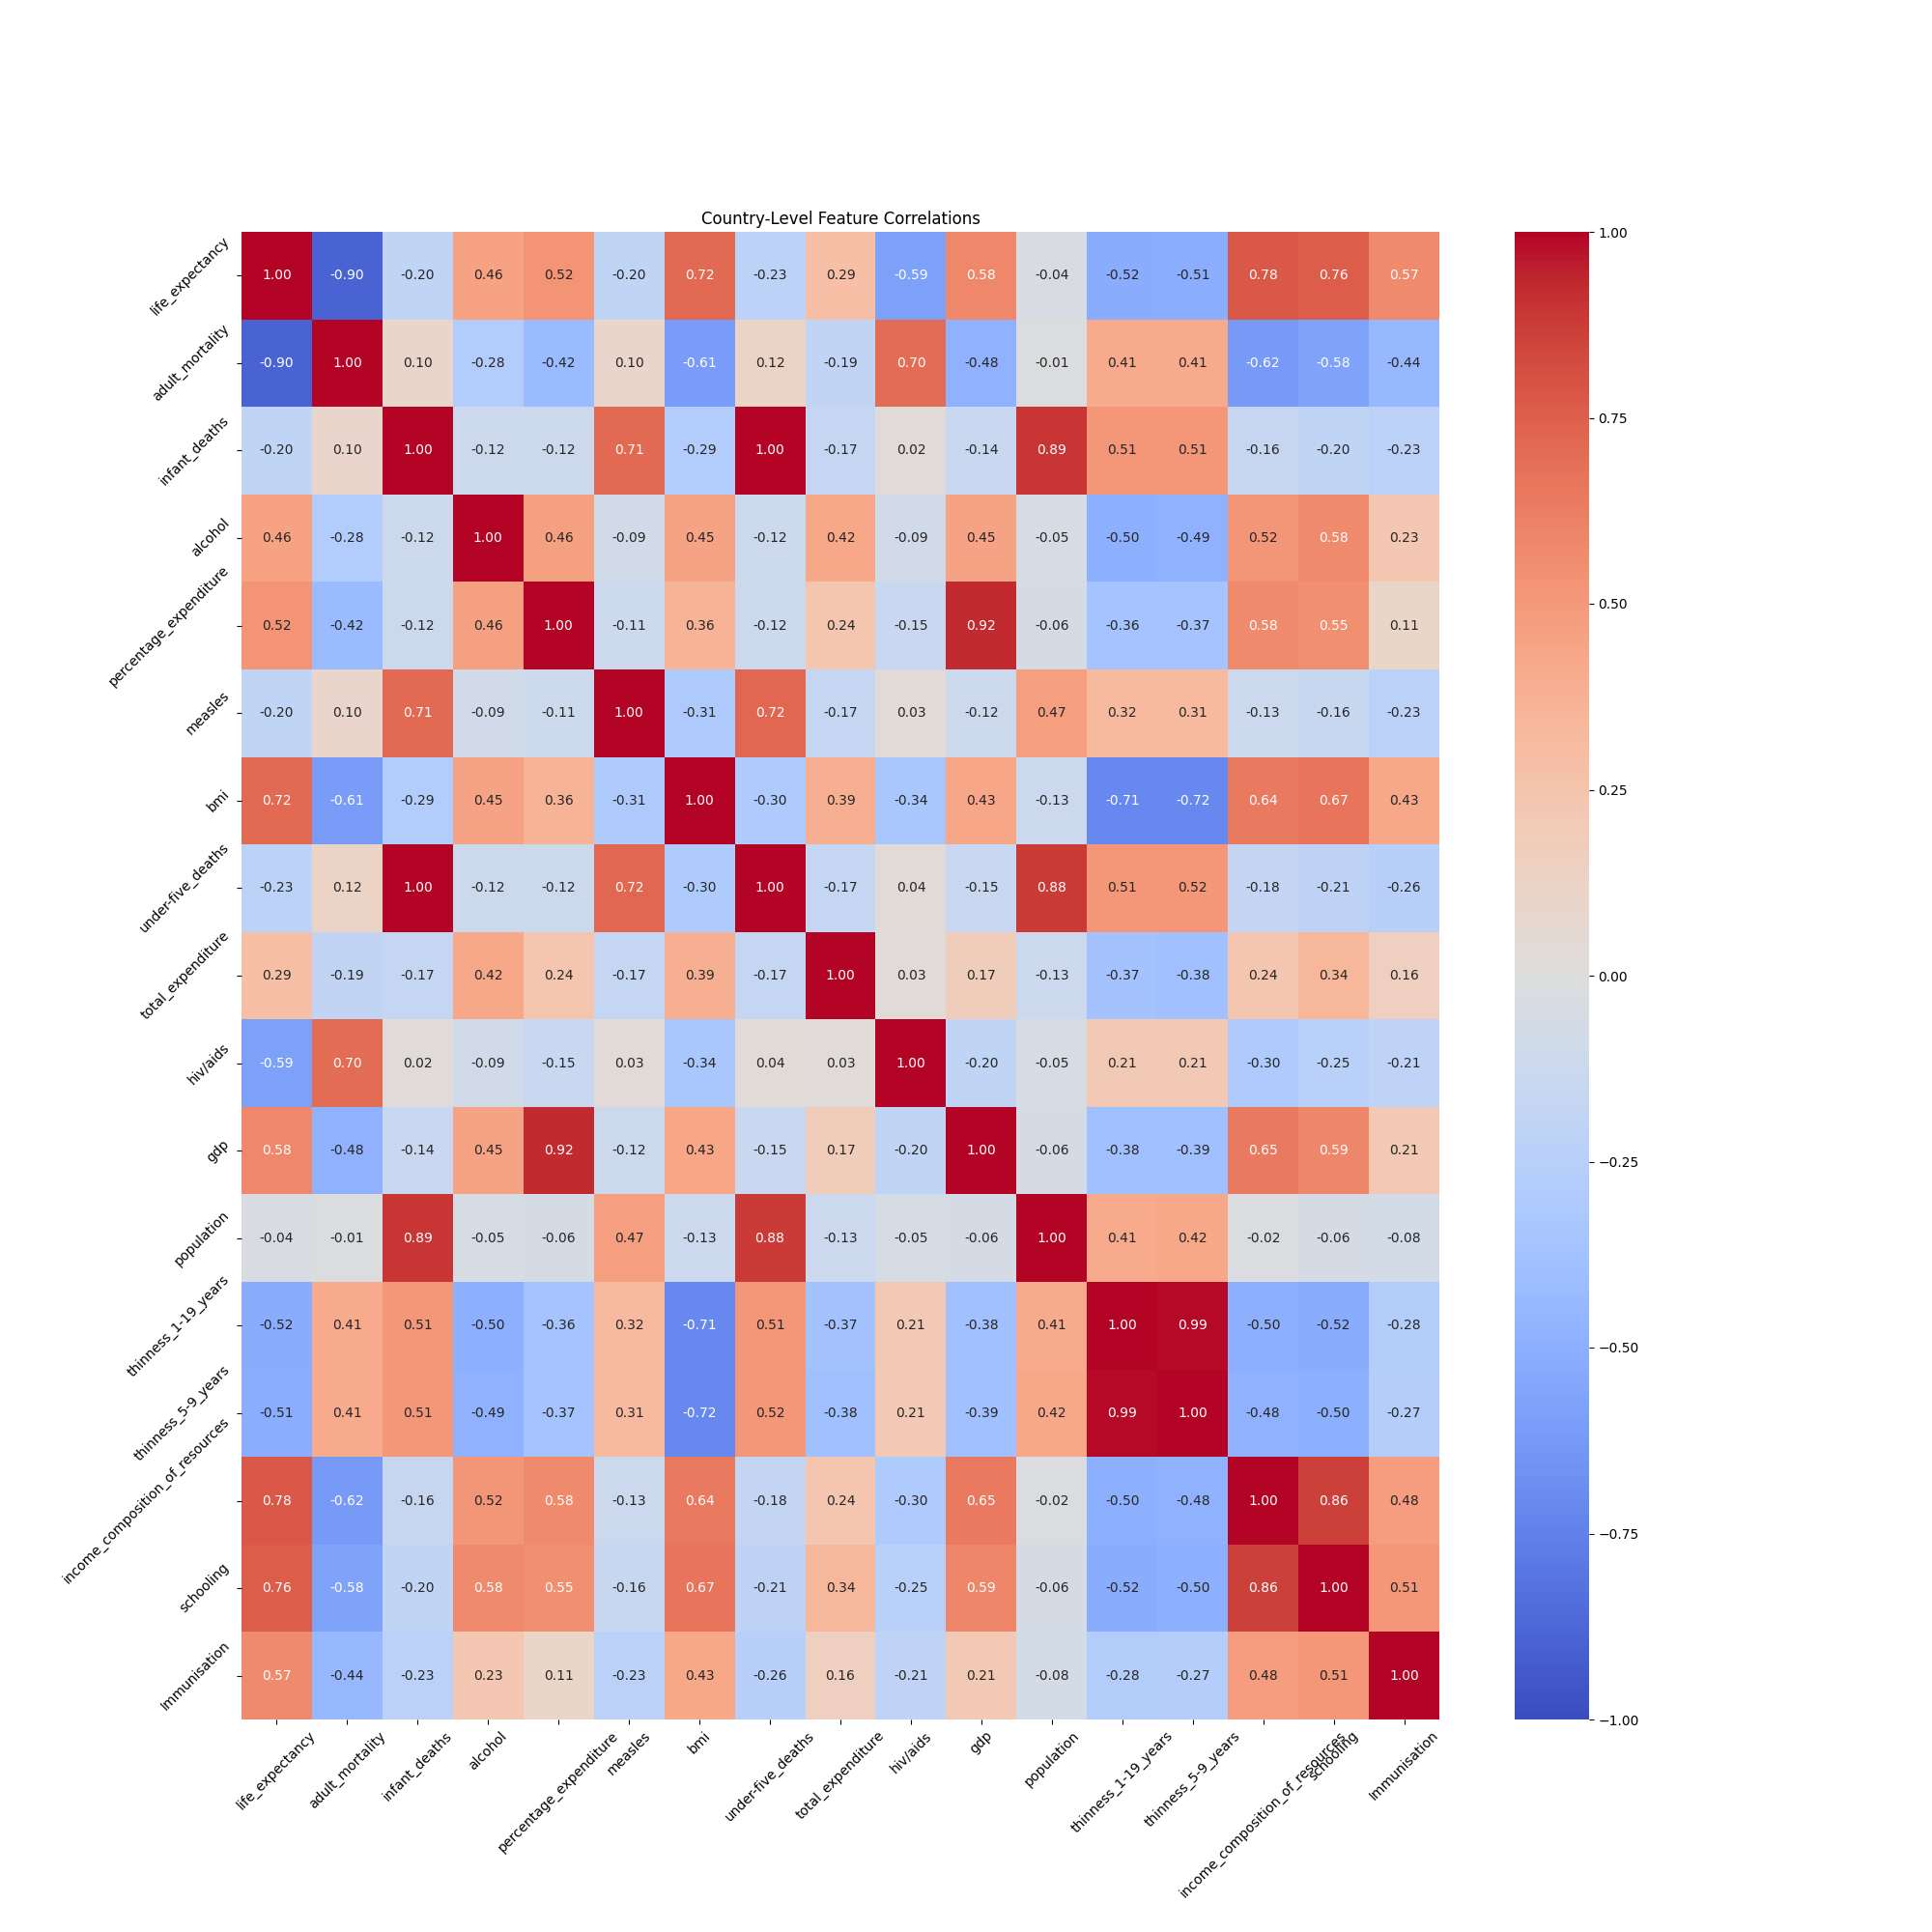

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,bmi,under-five_deaths,total_expenditure,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Immunisation
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,2362.2500,15.51875,107.5625,8.252500,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250,54.136444
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,53.3750,49.06875,0.9375,5.945625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750,98.068271
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,1943.8750,48.74375,23.5000,4.604000,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250,83.047650
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,3561.3125,18.01875,132.6250,3.919333,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375,44.977435
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,0.0000,38.42500,0.0000,4.791333,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375,96.195407


In [6]:
df = (
    df
    .dropna(subset=["life_expectancy"])
    .groupby("country", as_index=False)
    .mean(numeric_only=True)
    .pipe(
        lambda d: d.assign(
            **{
                col: d[col].fillna(d[col].mean())
                for col in d.columns
                if col != "country"
            }
        )
    )
 )

plt.figure(figsize=(20, 20))
(
    df
    .drop(columns=["country"])
    .corr()
    .pipe(
        lambda d: sns.heatmap(
            d,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
        )
    )
)
plt.tick_params(axis="both", rotation=45)
plt.title("Country-Level Feature Correlations")
plt.show()
df.head()

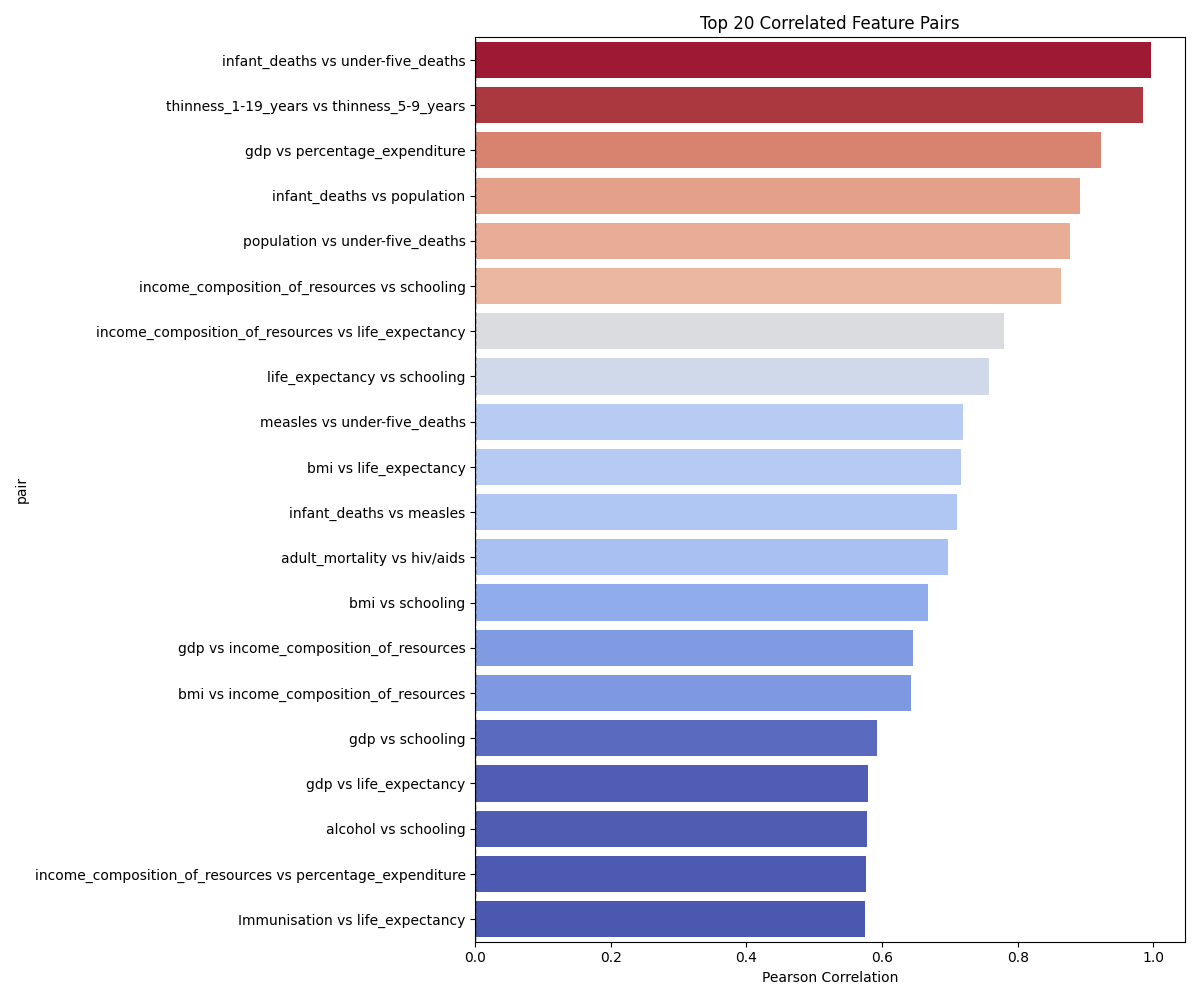

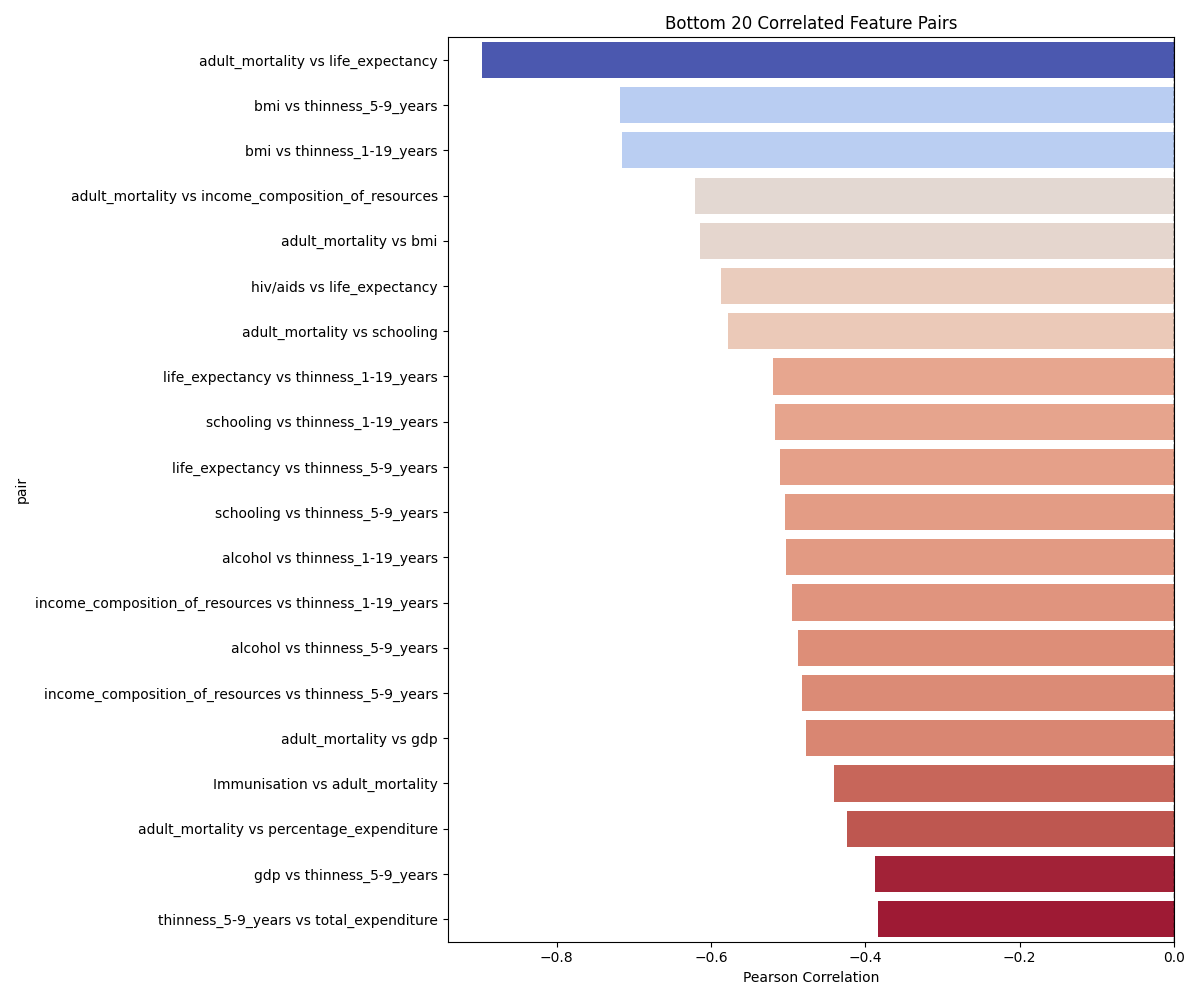

In [7]:
corr_pairs = (
    df
    .drop(columns=["country"])
    .corr()
    .stack()
    .reset_index(name="correlation")
    .query("level_0 < level_1")
    .assign(
        pair=lambda d: d.level_0 + " vs " + d.level_1,
        corr=lambda d: d.correlation,
    )
    .sort_values("correlation", ascending=False)
    .assign(rank=lambda d: d.index + 1)
 )
corr_pairs.head(10)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.head(20),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Top 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.tail(20).sort_values("correlation"),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Bottom 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_13536\680551281.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


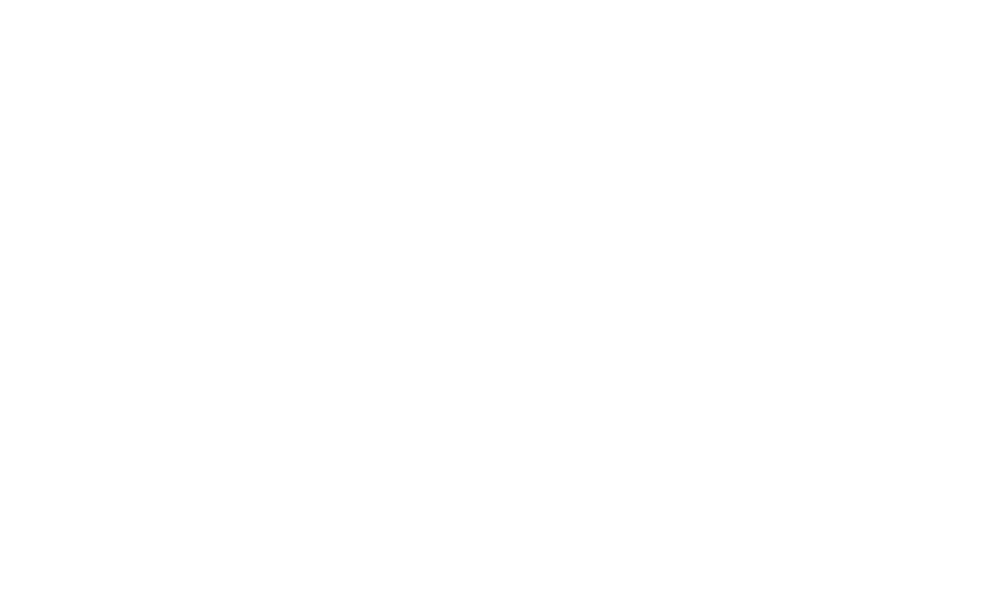

C:\Users\chris\AppData\Local\Temp\ipykernel_13536\680551281.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


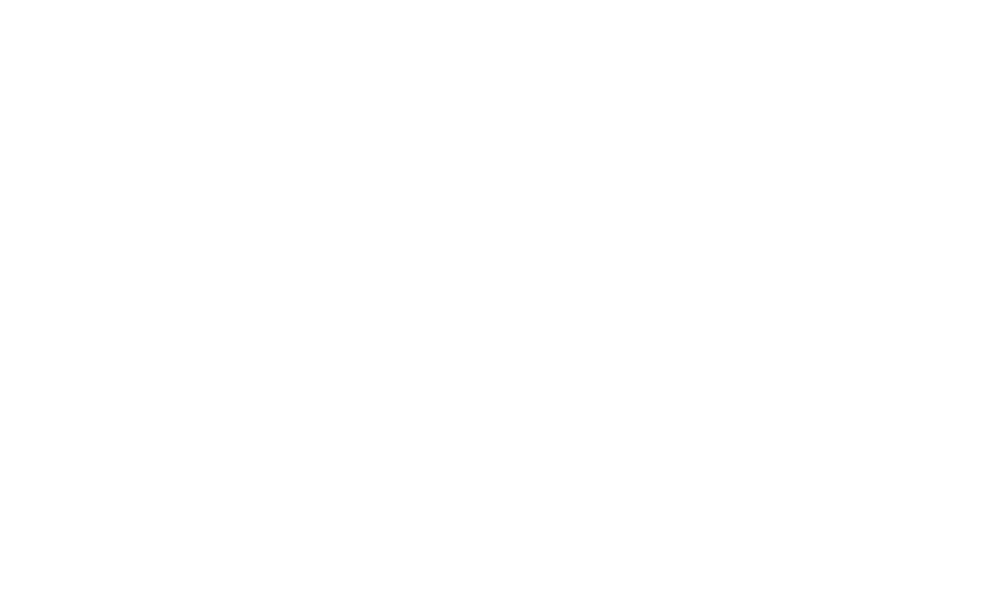

In [8]:
life_corr = (
    df
    .drop(columns=["country"])
    .corr()
    .loc["life_expectancy"]
    .drop("life_expectancy")
    .sort_values(ascending=False)
    .to_frame(name="correlation")
    .assign(feature=lambda d: d.index)
    .reset_index(drop=True)
 )
life_corr.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.head(10),
    x="correlation",
    y="feature",
    palette="coolwarm",
)
plt.title("Top Positive Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.tail(10).sort_values("correlation"),
    x="correlation",
    y="feature",
    palette="coolwarm",

)
plt.title("Top Negative Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

In [9]:
std_cols = df.drop(columns=["country"]).columns

df_std = (
    df
    .pipe(
        lambda d: pd.concat(
            [
                d[["country"]],
                pd.DataFrame(
                    StandardScaler().fit_transform(d[std_cols]),
                    columns=std_cols,
                    index=d.index,
                ),
            ],
            axis=1,
        )
    )
)
df.head()

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,bmi,under-five_deaths,total_expenditure,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Immunisation
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,2362.2500,15.51875,107.5625,8.252500,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250,54.136444
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,53.3750,49.06875,0.9375,5.945625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750,98.068271
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,1943.8750,48.74375,23.5000,4.604000,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250,83.047650
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,3561.3125,18.01875,132.6250,3.919333,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375,44.977435
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,0.0000,38.42500,0.0000,4.791333,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375,96.195407


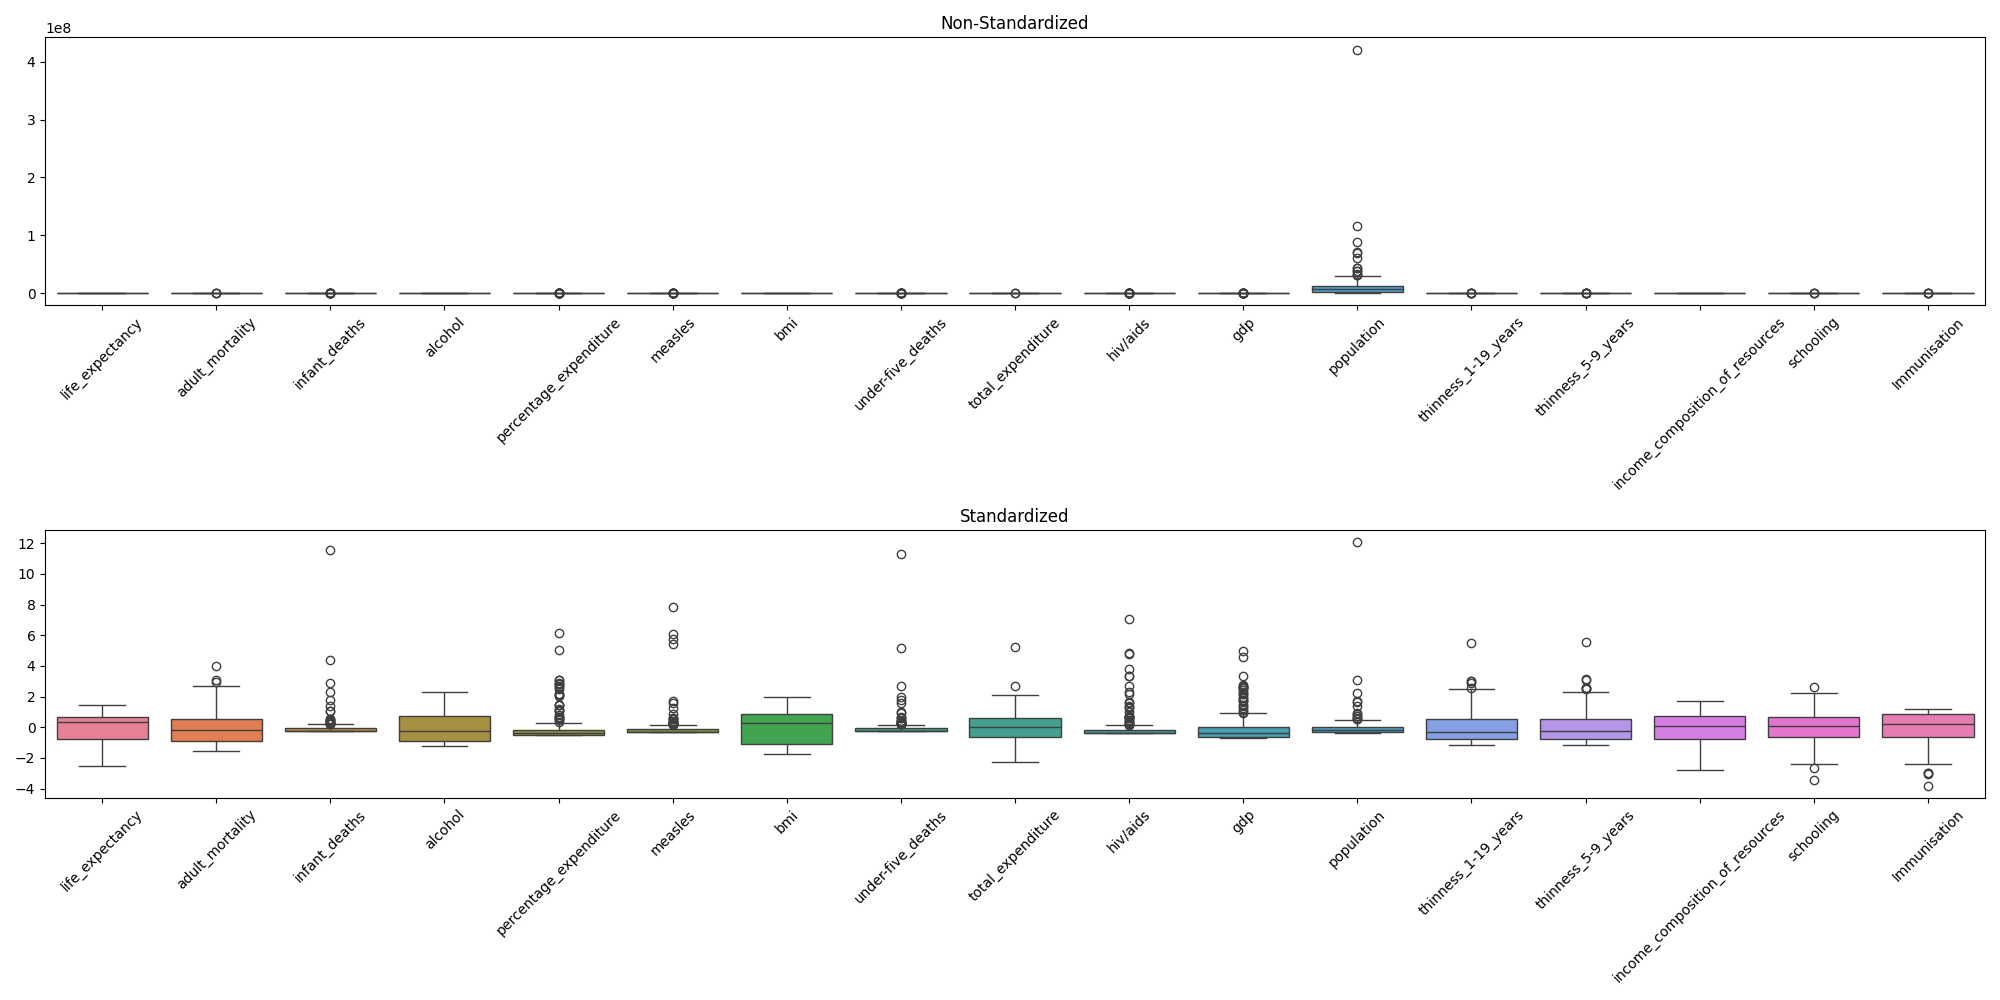

In [10]:
_, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(data=df[std_cols], ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('Non-Standardized')

sns.boxplot(data=df_std[std_cols], ax=axs[1])
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('Standardized')

plt.tight_layout()
plt.show()

In [11]:
df_std.describe()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,bmi,under-five_deaths,total_expenditure,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Immunisation
count,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02
mean,-7.231617e-16,8.736181e-17,9.706868e-18,-1.650168e-16,1.456030e-17,-3.397404e-17,1.310427e-16,4.853434e-18,1.504565e-16,-1.067755e-16,5.824121e-17,-5.824121e-17,-6.309464e-17,9.221525e-17,2.523786e-16,9.221525e-17,-4.565261e-16
std,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00
min,-2.522834e+00,-1.522554e+00,-2.628620e-01,-1.202433e+00,-5.012744e-01,-3.012648e-01,-1.714090e+00,-2.686629e-01,-2.237298e+00,-3.714860e-01,-7.242946e-01,-3.767145e-01,-1.169472e+00,-1.152694e+00,-2.783491e+00,-3.451146e+00,-3.795054e+00
25%,-7.367877e-01,-8.797794e-01,-2.628620e-01,-8.787960e-01,-4.793351e-01,-3.002488e-01,-1.099378e+00,-2.674686e-01,-6.408078e-01,-3.714860e-01,-6.318048e-01,-3.317210e-01,-7.617491e-01,-7.594363e-01,-7.803685e-01,-6.077156e-01,-6.229069e-01
50%,3.561251e-01,-1.900914e-01,-2.374683e-01,-2.376179e-01,-3.769155e-01,-2.795496e-01,2.817446e-01,-2.451752e-01,4.657220e-16,-3.714860e-01,-3.452094e-01,-1.951834e-01,-2.924828e-01,-2.622136e-01,1.134567e-01,7.429555e-02,2.443749e-01
75%,6.419744e-01,5.712694e-01,-7.159892e-02,7.616863e-01,-1.467274e-01,-1.118890e-01,8.715042e-01,-7.618325e-02,5.964985e-01,-1.692804e-01,1.816907e-16,-1.101330e-16,5.614280e-01,5.145085e-01,7.107439e-01,6.501932e-01,8.878651e-01
max,1.453131e+00,4.016451e+00,1.155169e+01,2.321520e+00,6.135570e+00,7.870833e+00,1.976957e+00,1.127613e+01,5.217302e+00,7.033325e+00,4.991661e+00,1.208329e+01,5.477185e+00,5.559812e+00,1.707041e+00,2.649867e+00,1.199091e+00


In [12]:
df_std = df_std.set_index("country")

In [13]:
df_std.columns

Index(['life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'total_expenditure', 'hiv/aids', 'gdp', 'population',
       'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'Immunisation'],
      dtype='object')

In [14]:
pred_cols = df_std.columns

pca = PCA()
pca_model = pca.fit(df_std[pred_cols])
pca_model

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [15]:
df_std[pred_cols].shape

(183, 17)

In [16]:
pca_model.components_.shape

(17, 17)

In [17]:
pca_model.components_[0]

array([ 0.31935841, -0.26638724, -0.19177353,  0.22744273,  0.23383568,
       -0.15482357,  0.30606473, -0.19691111,  0.16115776, -0.14950325,
        0.25125284, -0.13072767, -0.2978355 , -0.2968046 ,  0.29979115,
        0.30469056,  0.19847143])

In [18]:
loadings = (
    pd.DataFrame(
        pca_model.components_,
        columns=pred_cols,
        index=[f"PC{i+1}" for i in range(len(pred_cols))],
    )
    .T.reset_index()
    .rename(columns={"index": "feature"})
)
loadings

,feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,life_expectancy,0.319358,0.185010,-0.233837,0.028338,0.044014,0.096821,0.052679,-0.013745,-0.037893,0.235392,-0.272147,0.030882,0.313480,-0.335136,0.670010,-0.037768,-0.035145
1,adult_mortality,-0.266387,-0.209254,0.359201,-0.045324,0.147253,-0.183201,-0.085793,0.104065,0.027917,-0.436572,0.422258,-0.063257,0.209792,-0.291137,0.421021,-0.029710,-0.011925
2,infant_deaths,-0.191774,0.457470,0.066521,-0.140213,-0.033689,-0.012451,-0.124941,-0.031172,0.060864,-0.009683,-0.011766,-0.004236,-0.368398,-0.023411,0.210664,0.040578,0.725081
3,alcohol,0.227443,0.101545,0.359281,-0.179089,0.055112,0.012044,0.266584,0.773536,0.183874,0.247856,0.033314,-0.059107,-0.008028,0.029655,-0.055798,-0.011915,0.012282
4,percentage_expenditure,0.233836,0.157755,0.337547,0.471139,-0.119228,0.136738,-0.042589,-0.141875,0.203316,-0.033035,0.024686,0.162610,-0.119635,-0.601226,-0.289414,-0.024856,-0.005052
5,measles,-0.154824,0.338802,0.105807,-0.139945,-0.221831,-0.315375,0.648666,-0.321589,-0.037241,0.108273,0.159209,-0.021240,0.319548,-0.041965,-0.120553,-0.016249,-0.005283
6,bmi,0.306065,0.049096,-0.058293,-0.262913,-0.055020,-0.071259,-0.396568,-0.118935,-0.186736,0.434306,0.633641,-0.077075,0.039021,-0.100188,-0.095635,0.015235,0.002085
7,under-five_deaths,-0.196911,0.450098,0.082833,-0.140063,-0.051711,-0.015546,-0.108604,-0.024644,0.062235,0.000157,0.012239,0.004252,-0.445253,0.014434,0.207532,0.029206,-0.685871
8,total_expenditure,0.161158,-0.019893,0.295591,-0.429093,0.125767,0.724786,0.159634,-0.303913,-0.031667,-0.170107,0.009882,-0.092474,0.035568,0.055643,-0.003682,0.013836,-0.002019
9,hiv/aids,-0.149503,-0.162355,0.523554,-0.039158,0.411034,-0.249395,-0.156313,-0.269478,-0.083696,0.459958,-0.357141,0.015858,0.015266,0.027026,0.010324,-0.000432,-0.003298


In [19]:
aggregated_loadings = (
    loadings.set_index("feature")
    # .loc[:, ["PC1", "PC2", "PC3"]]
    .abs()
    .sum(axis=1)
    .sort_values(ascending=False)
)
aggregated_loadings

feature
adult_mortality                    3.314068
thinness_5-9_years                 3.111265
gdp                                3.107376
percentage_expenditure             3.104536
measles                            3.076400
thinness_1-19_years                2.993126
population                         2.991503
life_expectancy                    2.941654
income_composition_of_resources    2.939722
hiv/aids                           2.933789
bmi                                2.902071
Immunisation                       2.821638
schooling                          2.784757
total_expenditure                  2.634713
alcohol                            2.616463
under-five_deaths                  2.531590
infant_deaths                      2.512911
dtype: float64

In [20]:
top_loading_features = (
    aggregated_loadings
    .index
)

top_loading_features

Index(['adult_mortality', 'thinness_5-9_years', 'gdp',
       'percentage_expenditure', 'measles', 'thinness_1-19_years',
       'population', 'life_expectancy', 'income_composition_of_resources',
       'hiv/aids', 'bmi', 'Immunisation', 'schooling', 'total_expenditure',
       'alcohol', 'under-five_deaths', 'infant_deaths'],
      dtype='object', name='feature')

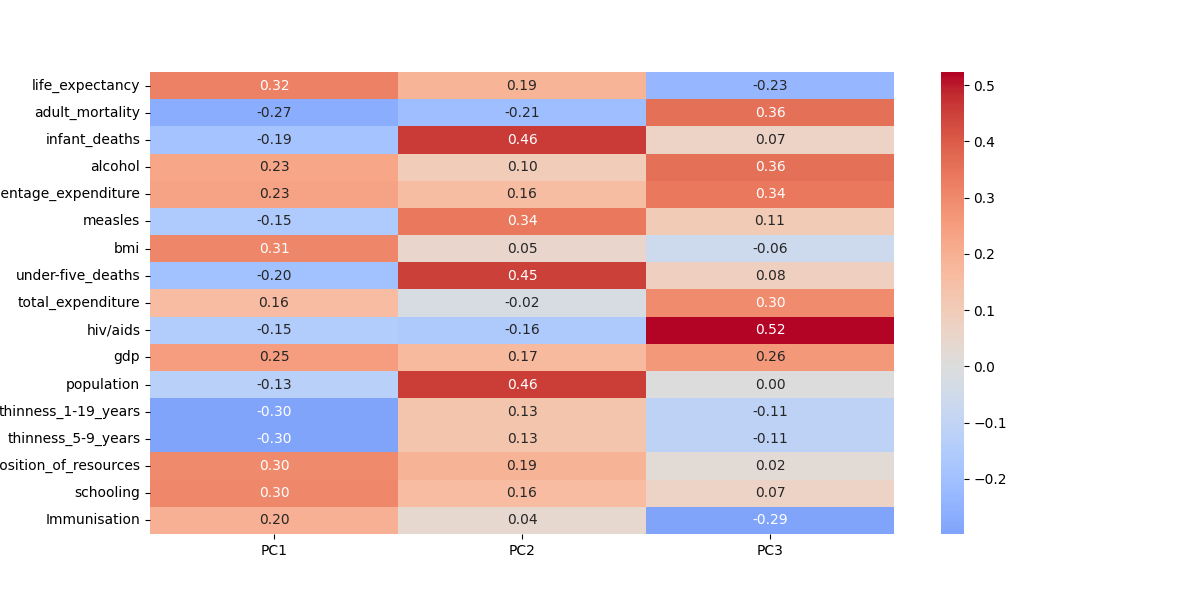

In [21]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    loadings
    .query("feature in @top_loading_features")
    .set_index("feature")
    .loc[:, ["PC1", "PC2", "PC3"]],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
)

plt.show()

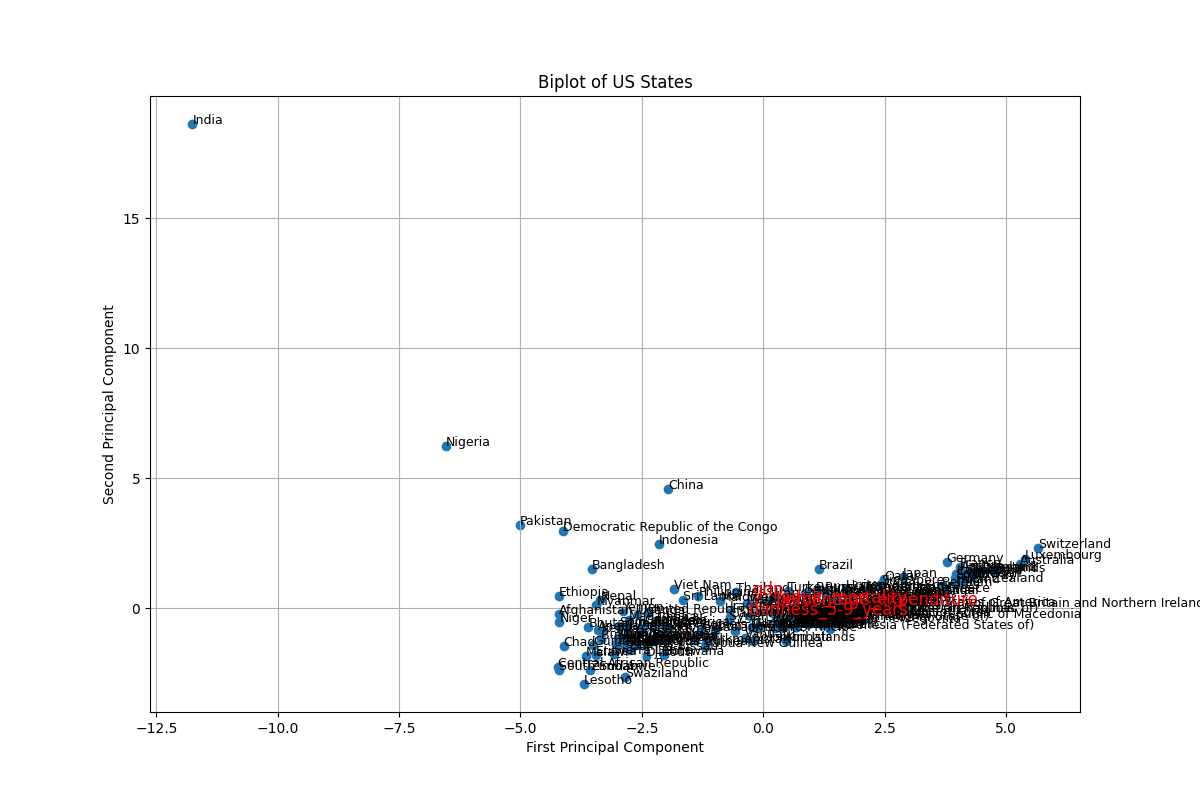

In [22]:
# Visualize states based on PC1 and PC2
plt.figure(figsize=(12, 8))
pc1 = pca_model.transform(df_std)[:, 0]
pc2 = pca_model.transform(df_std)[:, 1]
plt.scatter(pc1, pc2)

# add labels for each state
for i, state in enumerate(df_std.index):
    plt.text(pc1[i], pc2[i], state, fontsize=9)

# add arrows to illustrate contributions of original variables to the principal components
for i, var in enumerate(top_loading_features[:4]):
    plt.arrow(
        0,
        0,
        pca.components_[0, i],
        pca.components_[1, i],
        color="r",
        alpha=0.5,
        head_width=0.05,
        head_length=0.1,
    )
    plt.text(
        pca.components_[0, i] * 1.15,
        pca.components_[1, i] * 1.15,
        var,
        color="r",
        fontsize=12,
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Biplot of US States")
plt.grid(True)
plt.show()

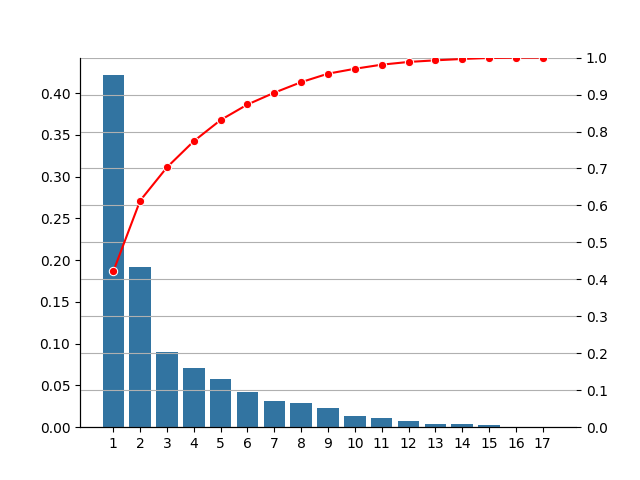

In [23]:
plt.figure()
ax = sns.barplot(
    x=np.arange(1, len(pred_cols) + 1),
    y=pca_model.explained_variance_ratio_,
)
ax = sns.lineplot(
    x=np.arange(0, len(pred_cols)),
    y=pca_model.explained_variance_ratio_.cumsum(),
    marker="o",
    color="red",
    ax=ax.twinx(),
)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
sns.despine(fig=plt.gcf(), top=True)
plt.show()